<a href="https://colab.research.google.com/github/TongkaiYang/Vision-Zero-Madison/blob/turrkey/CS_638_weekly_plots_(10_17).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import datetime as dt
sns.set(style="white")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
raw_df = pd.read_csv('drive/My Drive/CS 638/Madison_crash_2009_2019.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.



## Top reasons for different road types

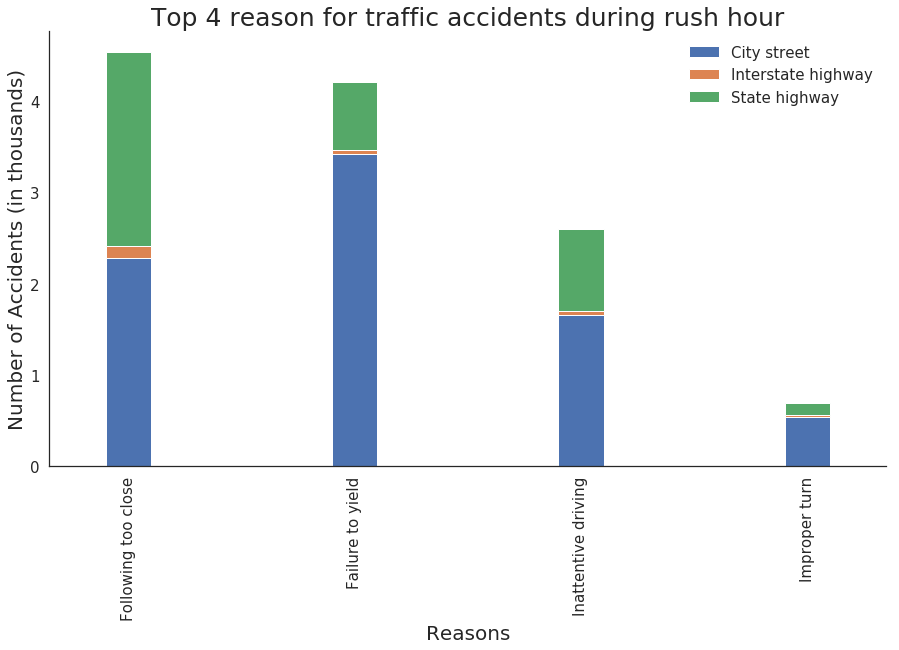

In [0]:
raw_df['ACCDDATE'] = pd.to_datetime(raw_df['ACCDDATE'])
week = [x.weekday() + 1 for x in raw_df['ACCDDATE']]
week_flag = ['weekday' if x >= 1 and x <= 5 else 'weekend' for x in week]
raw_df['week_flag'] = week_flag
rush_hour = raw_df[((raw_df['NTFYHOUR'] >= 6) & (raw_df['NTFYHOUR'] <= 9) & (raw_df['week_flag'] == 'weekday')) |
                    ((raw_df['NTFYHOUR'] >= 15) & (raw_df['NTFYHOUR'] <= 18) & (raw_df['week_flag'] == 'weekday'))].copy()
rush_hour['rush_flag'] = ['mrng_rush' if ((x >= 6) & (x <= 9)) else 'even_rush' for x in rush_hour['NTFYHOUR']]
rush_hour.dropna(subset = ['DRVRPC1'], inplace = True)
rush_hour_top_reason = rush_hour[rush_hour['DRVRPC1'].str.contains('FTC') | rush_hour['DRVRPC1'].str.contains('FTY') 
                                | rush_hour['DRVRPC1'].str.contains('ID') | rush_hour['DRVRPC1'].str.contains('IT')].reset_index(drop = True)
def top_reason(df):
  if 'FTC' in df['DRVRPC1']:
    flag = 'FTC'
  elif 'FTY' in df['DRVRPC1']:
    flag = 'FTY'
  elif'ID' in df['DRVRPC1']:
    flag = 'ID'
  elif 'IT' in df['DRVRPC1']:
    flag = 'IT'
  return flag
rush_hour_top_reason['reason'] = rush_hour_top_reason.apply(top_reason, axis = 1)
reason_hwyclass = rush_hour_top_reason.groupby(['reason', 'HWYCLASS']).count()['DOCTNMBR'].reset_index()
reason_hwyclass['DOCTNMBR'] = reason_hwyclass['DOCTNMBR'] / 1000.0
reason_hwyclass = pd.pivot_table(reason_hwyclass, values = 'DOCTNMBR', index = 'reason', columns = 'HWYCLASS')
rush_hour_reason_plt = reason_hwyclass.plot(kind="bar", stacked=True, width = 0.2)
rush_hour_reason_plt.set_xticklabels(['Following too close', 'Failure to yield', 'Inattentive driving', 
                                 'Improper turn'], rotation = 90, fontsize = 15)
rush_hour_reason_plt.set_yticklabels([0,1,2,3,4], fontsize = 15)
rush_reason_leg = rush_hour_reason_plt.get_legend_handles_labels()[0]
rush_hour_reason_plt.legend(rush_reason_leg, ['City street', 'Interstate highway', 'State highway'], title='', frameon = False, loc='upper right', prop={'size': 15})
rush_hour_reason_plt.spines['right'].set_visible(False)
rush_hour_reason_plt.spines['top'].set_visible(False)
rush_hour_reason_plt.set_title('Top 4 reason for traffic accidents during rush hour', fontsize = 25)
rush_hour_reason_plt.set_xlabel('Reasons', fontsize = 20)
rush_hour_reason_plt.set_ylabel('Number of Accidents (in thousands)', fontsize = 20)
plt.gcf().set_size_inches(15, 8)

These are the hour top reasons of car accident during rush hour of weekday.

Though the number of city street is a lot more than the number of highway, the ratio of car accident due to following to close in city street and highway is similar. 

## Detailed break down of 4 reasons above. Compare driver behavior during rush hour in both highway and city street

Text(0.5, 0.98, 'Comparison of driver behavior during rush hour between highway and city street')

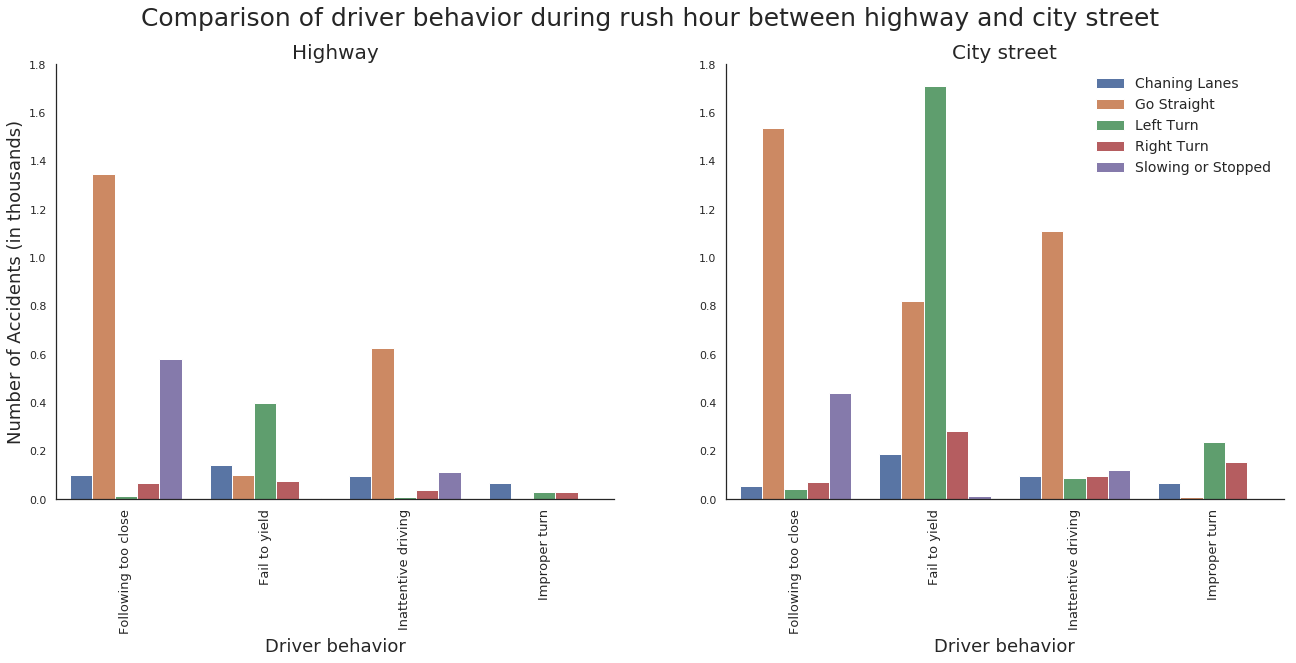

In [0]:
drv_do_hwy = rush_hour_top_reason[(rush_hour_top_reason['HWYCLASS'] == 'U IH') |
                                    (rush_hour_top_reason['HWYCLASS'] == 'U STH')].dropna(subset=['DRVRDO1']).groupby(['reason', 'DRVRDO1']).count()['DOCTNMBR'].reset_index()
drv_do_cstr = rush_hour_top_reason[(rush_hour_top_reason['HWYCLASS'] == 'U CITY')].dropna(subset=['DRVRDO1']).groupby(['reason', 'DRVRDO1']).count()['DOCTNMBR'].reset_index()
drv_do_hwy = drv_do_hwy[(drv_do_hwy['DRVRDO1'] == 'GO STR')|(drv_do_hwy['DRVRDO1'] == 'CHG LN')|(drv_do_hwy['DRVRDO1'] == 'LT TRN')
                        |(drv_do_hwy['DRVRDO1'] == 'SL/ST')|(drv_do_hwy['DRVRDO1'] == 'RT TRN')]
drv_do_cstr = drv_do_cstr[(drv_do_cstr['DRVRDO1'] == 'GO STR')|(drv_do_cstr['DRVRDO1'] == 'LT TRN')|(drv_do_cstr['DRVRDO1'] == 'RT TRN')
                        |(drv_do_cstr['DRVRDO1'] == 'SL/ST')|(drv_do_cstr['DRVRDO1'] == 'CHG LN')]
drv_do_hwy['DOCTNMBR'] = drv_do_hwy['DOCTNMBR'] / 1000
drv_do_cstr['DOCTNMBR'] = drv_do_cstr['DOCTNMBR'] / 1000
#print(drive_do_hwy)
#print(drive_do_cstr)
fig, ax =plt.subplots(1,2, figsize=(22, 8))

drv_do_hwy_plt = sns.barplot(x='reason', y='DOCTNMBR', hue='DRVRDO1', data=drv_do_hwy, ax = ax[0])
drv_do_cstr_plt = sns.barplot(x='reason', y='DOCTNMBR', hue='DRVRDO1', data=drv_do_cstr, ax = ax[1])
drv_do_hwy_plt.set_xticklabels(['Following too close', 'Fail to yield', 'Inattentive driving', 'Improper turn'], rotation = 90, fontsize = 13)
drv_do_cstr_plt.set_xticklabels(['Following too close', 'Fail to yield', 'Inattentive driving', 'Improper turn'], rotation = 90, fontsize = 13)
drv_do_hwy_plt.set_ylim(0, 1.8)
drv_do_cstr_plt.set_ylim(0, 1.8)

#drv_do_hwy_leg = drv_do_hwy_plt.get_legend_handles_labels()[0]
#drv_do_hwy_plt.legend(drv_do_hwy_leg, [''], title='', frameon = False, loc='upper right', prop={'size': 12})
drv_do_hwy_plt.legend_.remove()
drv_do_cstr_leg = drv_do_cstr_plt.get_legend_handles_labels()[0]
drv_do_cstr_plt.legend(drv_do_cstr_leg, ['Chaning Lanes', 'Go Straight', 'Left Turn', 'Right Turn', 'Slowing or Stopped'], title='', frameon = False, loc='upper right', prop={'size': 14})

drv_do_hwy_plt.spines['right'].set_visible(False)
drv_do_hwy_plt.spines['top'].set_visible(False)
drv_do_hwy_plt.set_title('Highway', fontsize = 20)
drv_do_hwy_plt.set_xlabel('Driver behavior', fontsize = 18)
drv_do_hwy_plt.set_ylabel('Number of Accidents (in thousands)', fontsize = 18)

drv_do_cstr_plt.spines['right'].set_visible(False)
drv_do_cstr_plt.spines['top'].set_visible(False)
drv_do_cstr_plt.set_title('City street', fontsize = 20)
drv_do_cstr_plt.set_xlabel('Driver behavior', fontsize = 18)
drv_do_cstr_plt.set_ylabel('')

fig.suptitle('Comparison of driver behavior during rush hour between highway and city street', fontsize = 25)



*   Following too close in highway is more than that in city street, even though number of city streets is a lot more than highway.
*   Left turn takes the majority of traffic accident caused by fail to yield in city street.
*   Changing lanes happend more frequently than go straight for traffic accident caused by fail to yield in highway.



